### Xử lý ảnh trưng bày hàng hóa bằng Yolov5
Input:
- file ảnh
- file label (yolov5 annotation)

Output:
- Thông tin các box trong ảnh
- Sắp xếp các box theo thứ tự mong muốn
- Kiểm tra cách sắp xếp của các box trong từng hàng
- Đếm số khoảng trống của từng hàng

### Helper function:
- print_is_contains_same_objects
    - input: 
        - num_o: số lượng object cần check xem có nằm liên tiếp không
        - check_label: nhãn của các object cần check
        - check_line: hàng (cột) cần xét
    - output: true/ false nếu line (hàng/ cột) *check_line* tồn tại *num_o* box nhãn *check_label* liên tiếp
    - Các bước xử lý:
        1. Lọc ra các object nằm ở hàng (cột) *check_line*, gán vào biến *label_obj_inline*
        2. Dùng built-in functions của python (*any*) để kiểm tra hàng (cột)
<br><br/>
- print_is_contains_list_objects:
    - input: 
        - label_list: list các label (Ex: [0,1,2])
        - check_line: hàng (cột) cần xét
    - output: true/ false nếu line (hàng/ cột) *check_line* tồn tại label_list* 

In [1]:
from decimal import DivisionUndefined
from statistics import *
import numpy as np
import argparse
import imutils
import cv2
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


LABELS = []
LINES = []

class Image_Market:
    """ shelves photo taken by retailer
    """
    def __init__(self, path_img, path_label = ''):
        self.path_image = path_img
        self.path_label = path_label
        self.nBox = 0
        self.nLabel = 0
        
        self.labels = []
        self.lines = []
        
        self.boxs:list[Box] = []
        self.contours = ()
        self.mean_width, self.mean_height = 0,0
        
        self.dict_linebox = {}
        self.dict_lineblank = {}
        self.method_sort = "top-to-bottom"
        self.method_sort_2nd = "left-to-right"
        self.image_data = self.read_image(path_img, path_label)
        
    def set_method_sort(self, sort_order = 0, method_name = "top-to-bottom"):
        """ Thiết lập chiểu sắp xếp

        Args:
            sort_order (int, optional): Lần sắp xếp đầu tiên hay thứ 2. Defaults to 0.
            method_name (str, optional): Chiều sắp xếp.
                ('top-to-bottom', 'left-to-right', ...)
                Defaults to "top-to-bottom".
        """
        if sort_order == 0:
            self.method_sort = method_name
        else:
            self.method_sort_2nd = method_name
        
    def read_image(self, path_img, path_label):
        # global LABELS
        fl = open(path_label, 'r')
        coords = fl.readlines()
        fl.close()
        
        img = cv2.imread(path_img) #args["image"])
        self.img_h, self.img_w = img.shape[0:2]

        self.init_box_objects_from_txt(coords)
        self.set_mean_wh()
        self.set_center_text()
        return img
    
    def init_box_objects_from_txt(self, coords: list[str]):
        """Khởi tạo thông tin các box trong ảnh

        Args:
            coords (list): list chứa từng phần tử là từng dòng trong file label
        """
        global LABELS
        tmp_contours = ()
        for (count, dt) in enumerate(coords):            
            # class x_center y_center width height
            dt_split = dt.split(' ')
            dt_split_int = list(map(lambda x: float(x), dt_split))
            _, tmp_x_cen, tmp_y_cen, tmp_box_w, tmp_box_h = dt_split_int
            self.labels += [int(_)]
            # get ABCD (numpy array)
            tmp_box = Box(int(_), tmp_x_cen, tmp_y_cen, tmp_box_w, tmp_box_h, self, count)
            self.boxs += [tmp_box]
            
            tmp_ABCD = tmp_box.get_corners_contour()
            # print(tmp_xy1xy2)
            # draw.rectangle(tmp_xy1xy2, outline=(0, 0, 0, 255), width=10)
            tmp_contours = tmp_contours + (tmp_ABCD, )
        self.nBox = len(self.boxs)
        self.nLabel = len(set(self.labels))
        self.contours = tmp_contours
        LABELS = self.labels
        # return tmp_contours
            
    
    def sort_box(self, method="top-to-bottom"):
        """Sắp xếp các box (lần đầu)

        Args:
            method (str, optional): Chiều sắp xếp. Defaults to "top-to-bottom".
        """
        self.method_sort = method
        global LABELS
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
        # handle if we are sorting against the y-coordinate rather than
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
        # construct the list of bounding boxes and sort them from top to bottom
 
        self.boxs = sorted(self.boxs, key = lambda b: (b.point_sort)[i], reverse=reverse)

        
    def divide_line_image(self):
        """Chia line (sau khi đã sắp xếp lần 1)
        """
        tmp_reverse = False
        i = 0
        if self.method_sort == "right-to-left" or self.method_sort == "bottom-to-top":
            tmp_reverse = True
        if self.method_sort == "top-to-bottom" or self.method_sort == "bottom-to-top":
            i = 1
        self.boundingBoxes = [x.boundingBox for x in self.boxs]    
        self.lines = divide_line(self.boundingBoxes, i)
        for (count, value) in enumerate(self.lines):
            self.boxs[count].line_number = value
            self.boxs[count].index_curr = count
        self.update_data()
        
        #   update dict_linebox
        set_label = set(self.lines)
        for x in set_label:
            self.dict_linebox[x] = []
        for (count, value) in enumerate(self.boxs):
            self.dict_linebox[value.line_number] += [value]
            # self.dict_linebox[value.line_number] += [value.index_curr]
        
            
    def sort_internal_line(self):
        """ Sắp xếp box trong từng line (sau khi sắp xếp box cả hình và chia line)
        """
        tmp_reverse = False
        i = 0
        if self.method_sort_2nd == "right-to-left" or self.method_sort == "bottom-to-top":
            tmp_reverse = True
        if self.method_sort_2nd == "top-to-bottom" or self.method_sort == "bottom-to-top":
            i = 1
        set_label = set(self.lines)
        tmp_boxes = []
        for x in set_label:
            tmp_subboxes = self.dict_linebox[x]
            # print(tmp_subboxes[0].x1)
            tmp_subboxes = sorted(tmp_subboxes, key = lambda b: (b.point_sort)[i], reverse=tmp_reverse)
            self.dict_linebox[x] = tmp_subboxes
            tmp_boxes += tmp_subboxes
            
        # print(tmp_boxes)        
        self.boxs = tmp_boxes
        self.update_data()
        
    
    def print_is_contains_same_objects(self, num_o:int, check_label:int, check_line:int):
        """ Kiểm tra hàng check_line có num_o hộp nhãn check_label liên tiếp không

        Args:
            num_o (int): số box
            check_label (int): label cần check
            check_line (int): số thứ tự line
        """
        print(self.is_contains_same_objects(num_o, check_label, check_line))
        
    def is_contains_same_objects(self, num_o, check_label, check_line):
        lines_list = self.lines 
        labels_list = self.labels
        label_obj_inline = []
        for (i,c) in enumerate(labels_list):
            if lines_list[i] == check_line:
                label_obj_inline += [c]
        
        res = any([check_label]*num_o == label_obj_inline[i:i+num_o] for i in range(len(label_obj_inline) - 1))
        return res
    
    def print_is_contains_list_objects(self, label_list:list[int], check_line:int):
        """Kiểm tra 1 hàng có tồn tại list các box theo label cho trước không

        Args:
            label_list (list): list các label (Ex: [0,1,2])
            check_line (int)
        """
        print(self.is_contains_list_objects(label_list, check_line))
        
    def is_contains_list_objects(self, label_list, check_line):
        lines_list = self.lines 
        labels_list = self.labels
        label_obj_inline = []
        for (i,c) in enumerate(labels_list):
            if lines_list[i] == check_line:
                label_obj_inline += [c]
        
        res = any(label_list == label_obj_inline[i:i+len(label_list)] for i in range(len(label_obj_inline) - 1))
        return res
    
    def update_data(self):
        """Đồng bộ thông tin các attribute trong class
        """
        # labels
        for (count, value) in enumerate(self.labels):
            (self.labels)[count] = (self.boxs)[count].label
        tmp_contours = ()
        #   each box's index; image's contours
        for (count, value) in enumerate(self.boxs):
            value.index_curr = count
            tmp_ABCD = value.get_corners_contour()
            tmp_contours = tmp_contours + (tmp_ABCD, )
        self.contours = tmp_contours
        
        self.boundingBoxes = []
        self.boundingBoxes = [x.boundingBox for x in self.boxs]
        
        if self.center_text == 'line':
            self.center_texts = self.lines
            return
        if self.center_text == 'box':
            self.center_texts = list(range(self.nBox))
    
    def print_status_lines(self):
        self.set_status_lines()
        for num_l, nblank in self.dict_lineblank.items():
            print('the number of blank position in line ', num_l, ': ', nblank)
                
    def set_status_lines(self):
        self.set_mean_wh()
        # print(self.mean_height, self.mean_width)
        self.dict_lineblank = {}
        for num_l, boxes in self.dict_linebox.items():
            tmp_nblank = 0
            for count, box in enumerate(boxes):
                if count == 0: continue
                # if boxes[count-1].x2 + self.mean_width < box.x1:
                #     tmp_nblank += 1
                tmp_nblank += int((box.x1 - boxes[count-1].x2) / self.mean_width)
                    
            self.dict_lineblank[num_l] = tmp_nblank
                    
    def set_mean_wh(self):
        box_ws = [x.box_width_pixel for x in self.boxs]
        box_hs = [x.box_height_pixel for x in self.boxs]
        self.mean_height, self.mean_width = mean(box_hs), mean(box_ws)
        
    def print_boxes(self):
        for (count, box_curr) in enumerate(self.boxs):
            box_curr.print_point_sort()
    
    def set_center_text(self, order = 'line'):
        """Set up text trung tâm của từng box trước khi vẽ

        Args:
            order (str, optional):
                'line' (stt dòng) hoặc 'box' (stt box)
                Defaults to 'line'.
        """
        self.center_text = order
        if order == 'line':
            self.center_texts = self.lines
            return
        if order == 'box':
            self.center_texts = list(range(self.nBox))
        
    
    def show_imageboxs(self):
        """Vẽ hình
        """
        for (i, c) in enumerate(self.contours):
            # print(i)
            # print(ROWS[i])
            draw_contour(self.image_data, c, self.center_texts[i])
        img = cv2.drawContours(self.image_data, self.contours, -1, (0,255,0), 3)
        # print(img)
        # imS = cv2.resize(img, (500, 800))     
        # cv2.imshow("Sorted", imS)

        # cv2.imshow('bounding', cv2.resize(cv2.drawContours(img, res, -1, (0,255,0), 3), (600, 900))  )
        #########################################################
        figure(figsize=(20,15))
        plt.imshow(img)
        plt.show()

        # cv2.waitKey(0)
        
        
class Box:
    def __init__(self, label, x_center, y_center, box_width, box_height, img: Image_Market, index = 0):
        self.index_init = self.index_curr = index
        self.label = label
        self.x_center = x_center
        self.y_center = y_center
        self.box_width_ratio = box_width
        self.box_height_ratio = box_height
        
        self.box_width_pixel = box_width * img.img_w
        self.box_height_pixel = box_height * img.img_h
        
        self.image = img
        self.line_number = 0
        
        self.init_corner_coordandcontours()
        self.set_point_sort()
        self.boundingBox = cv2.boundingRect(self.corners_contour)
        
    def init_corner_coordandcontours(self):
        self.corners_contour = get_cornercoords(self.x_center, self.y_center, 
                                            self.box_width_ratio, self.box_height_ratio,
                                            self.image.img_w, self.image.img_h)
        self.xy1xy2 = get_recfromcorners(self.corners_contour)
        self.x1, self.x2, self.y1, self.y2 = self.xy1xy2
        

    def print_corner_xy1xy2(self):
        print(self.xy1xy2)
        
    def get_corner_xy1xy2(self):
        return self.xy1xy2
        
    def print_corners_contour(self):
        print(self.corners_contour)
        
    def get_corners_contour(self):
        return self.corners_contour
        
    def set_point_sort(self, option = 'top-left'):
        self.point_sort_option = option
        if option == 'center':
            self.point_sort = get_center_rec(self.xy1xy2)
            return
        op = option.split('-')
        x = self.x1 if op[1] == 'left'  else self.x2
        y = self.y1 if op[0] == 'top'   else self.y2
        self.point_sort = [x, y]
        
    def get_point_sort(self):
        return self.point_sort
    
    def print_point_sort(self):
        print ('box', self.index_curr, '\tline: ',self.line_number,'\tlabel:', self.label)
        print (self.point_sort_option, 'point: ', (self.point_sort)[0],'; ', (self.point_sort)[1])
        print ('-'*10)


def divide_line(boundingBoxes, i_ex):
    rows = [0 for i in range(len(boundingBoxes))]
    row_max = 0
    for (i, c) in enumerate(boundingBoxes):
        if i == 0: continue
        if not is_sameline(boundingBoxes[i][i_ex], boundingBoxes[i-1][i_ex]):
            row_max += 1
        rows[i] = row_max
    print ('row list:',rows)
    return rows

    
def is_sameline(value1, value2, threshold = 50):
    return abs(value1 - value2) < threshold    


def draw_contour(image, c, i):
	# compute the center of the contour area and draw a circle
	# representing the center
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
 
	# draw the countour number on the image
	cv2.putText(image, "#{}".format(i), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,
		1.0, (255, 255, 255), 2)
 
	# return the image with the contour number drawn on it
	return image


def get_recfromcorners(corners_np):
    """generate x1, x2, y1, y2 from 4 corners (contours opencv format)

    Args:
        corners_np:
            [
                [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
                ...
            ]

    Returns:
        [
            [x1, x2, y1, y2],
            ...
        ]
    """
    # print(corners_np)
    x1 = corners_np[0][0][0]
    y1 = corners_np[0][0][1]
    x2 = corners_np[2][0][0]
    y2 = corners_np[2][0][1]
    return [x1, x2, y1, y2]

    
def get_cornercoords(x_center, y_center, box_width, box_height, image_width, image_height):
    """get corners list (contours opencv format)

    Args:
        x_center (float): abscissa (x axis) of box center
        y_center (float): ordinate (y axis)of box center
        box_width (float):
        box_height (float):
        image_width (float):
        image_height (float):

    Returns:
        np_array([[x1, y1]], [[x2,y1]], [[x2,y2]], [[x1,y2]]): array of corners coordinates in numpy format
    """
    # class x_center y_center width height
    x1 = image_width * (x_center - box_width / 2)
    x2 = image_width * (x_center + box_width / 2)
    
    y1 = image_height * (y_center - box_height / 2)
    y2 = image_height * (y_center + box_height / 2)
    
    corners = [[[x1, y1]], [[x2,y1]], [[x2,y2]], [[x1,y2]]]
    corners_np = np.array(corners, dtype=np.dtype(np.int32))
    
    return corners_np


def get_center_rec(x12y12):
    """get center(x, y) from x1, x2, y1, y2 coordinates

    Args:
        x12y12: [x1, x2, y1, y2]

    Returns:
        [x_aver, y_aver]
    """
    x1, x2, y1, y2 = x12y12
    return [(x1 + x2) / 2, (y1 + y2) / 2]


def draw_box(frame, bbox, color=(255,0,0)):
	x1, y1, x2, y2 = bbox
	cv2.rectangle(frame, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=2)
	return frame

def IOU(box1, box2):
	""" We assume that the box follows the format:
		box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
		where (x1,y1) and (x3,y3) represent the top left coordinate,
		and (x2,y2) and (x4,y4) represent the bottom right coordinate """
	x1, y1, x2, y2 = box1	
	x3, y3, x4, y4 = box2
	x_inter1 = max(x1, x3)
	y_inter1 = max(y1, y3)
	x_inter2 = min(x2, x4)
	y_inter2 = min(y2, y4)
	width_inter = abs(x_inter2 - x_inter1)
	height_inter = abs(y_inter2 - y_inter1)
	area_inter = width_inter * height_inter
	width_box1 = abs(x2 - x1)
	height_box1 = abs(y2 - y1)
	width_box2 = abs(x4 - x3)
	height_box2 = abs(y4 - y3)
	area_box1 = width_box1 * height_box1
	area_box2 = width_box2 * height_box2
	area_union = area_box1 + area_box2 - area_inter
	iou = area_inter / area_union
	return iou


- Khai báo đường dẫn đến file image và file label
- Hàm sort_box() dùng để sắp xếp các box (theo thứ tự mặc định: top-bottom)
- Hàm divide_line_image(): chia các box đã sắp xếp thành từng line (ở đây sẽ chia thành từng hàng do method sắp xếp là top-to-bottom)

In [2]:
image_path = 'datasets/data_th/images/val/THM_297.jpg'
label_path = 'datasets/data_th/labels/val/THM_297.txt'

image_o = Image_Market(image_path, label_path)

image_o.sort_box('top-to-bottom')
image_o.divide_line_image()

image_o.print_boxes()



row list: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
box 0 	line:  0 	label: 1
top-left point:  449 ;  1000
----------
box 1 	line:  0 	label: 1
top-left point:  559 ;  1002
----------
box 2 	line:  0 	label: 1
top-left point:  349 ;  1004
----------
box 3 	line:  0 	label: 1
top-left point:  651 ;  1004
----------
box 4 	line:  0 	label: 1
top-left point:  754 ;  1011
----------
box 5 	line:  1 	label: 3
top-left point:  664 ;  1380
----------
box 6 	line:  1 	label: 3
top-left point:  754 ;  1382
----------
box 7 	line:  1 	label: 0
top-left point:  473 ;  1390
----------
box 8 	line:  1 	label: 1
top-left point:  565 ;  1392
----------
box 9 	line:  1 	label: 0
top-left point:  379 ;  1392
----------
box 10 	line:  1 	label: 2
top-left point:  1648 ;  1400
----------
box 11 	line:  1 	label: 2
top-left point:  1723 ;  1402
----------
box 12 	line:  1 	label: 2
top-left point:  1489 ;  1403
----------
box 13 	line:  1 	label: 2
top-left point:  1568 ;

- set_method_sort(1, 'left-to-right'): thiết lập tại lần sắp xếp thứ 2 (xếp trên line), xếp theo chiều left-right
- sort_internal_line(): sắp xếp theo line

In [3]:
image_o.set_method_sort(1, 'left-to-right')
image_o.sort_internal_line()
image_o.print_boxes()

box 0 	line:  0 	label: 1
top-left point:  349 ;  1004
----------
box 1 	line:  0 	label: 1
top-left point:  449 ;  1000
----------
box 2 	line:  0 	label: 1
top-left point:  559 ;  1002
----------
box 3 	line:  0 	label: 1
top-left point:  651 ;  1004
----------
box 4 	line:  0 	label: 1
top-left point:  754 ;  1011
----------
box 5 	line:  1 	label: 0
top-left point:  379 ;  1392
----------
box 6 	line:  1 	label: 0
top-left point:  473 ;  1390
----------
box 7 	line:  1 	label: 1
top-left point:  565 ;  1392
----------
box 8 	line:  1 	label: 3
top-left point:  664 ;  1380
----------
box 9 	line:  1 	label: 3
top-left point:  754 ;  1382
----------
box 10 	line:  1 	label: 2
top-left point:  1489 ;  1403
----------
box 11 	line:  1 	label: 2
top-left point:  1568 ;  1403
----------
box 12 	line:  1 	label: 2
top-left point:  1648 ;  1400
----------
box 13 	line:  1 	label: 2
top-left point:  1723 ;  1402
----------
box 14 	line:  1 	label: 2
top-left point:  1803 ;  1403
----------


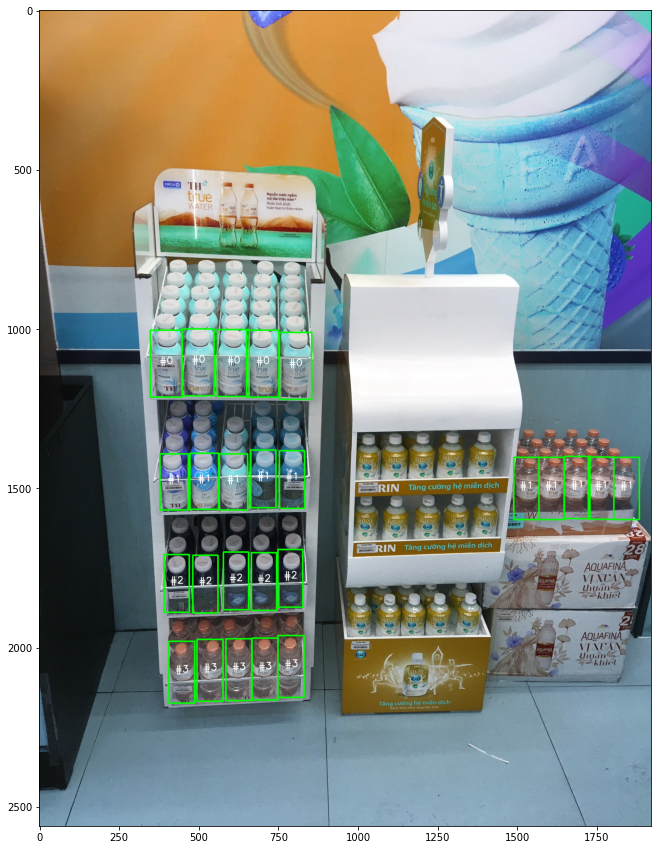

In [4]:
image_o.set_center_text('line')
image_o.show_imageboxs()

- Kiểm tra line có index = 1 có 2 box label 0 liên tiếp

In [5]:
image_o.print_is_contains_same_objects(2,0,1)

True


- Kiểm tra line có index = 1 có 3 box label lần lượt là 0, 2, 3

In [6]:
image_o.print_is_contains_list_objects([0,2,3],1)

False


- In số khoảng trống ở mỗi line

In [7]:
image_o.print_status_lines()

the number of blank position in line  0 :  0
the number of blank position in line  1 :  7
the number of blank position in line  2 :  0
the number of blank position in line  3 :  0
